In [ ]:
#pip install kornia
#pip install kornia-rs
#pip install kornia_moons
#pip install opencv-python --upgrade
#pip install opencv-python

In [1]:
import io

import requests


def download_image(url: str, filename: str = "") -> str:
    filename = url.split("/")[-1] if len(filename) == 0 else filename
    # Download
    bytesio = io.BytesIO(requests.get(url).content)
    # Save file
    with open(filename, "wb") as outfile:
        outfile.write(bytesio.getbuffer())

    return filename


In [2]:
from PIL import Image


In [3]:
url_a = Image.open('Blue_morpho_butterfly.jpg')
url_b = Image.open('Sunflower.jpg')

In [4]:
import cv2
import kornia as K
import kornia.feature as KF
import matplotlib.pyplot as plt
import numpy as np
import torch
from kornia_moons.viz import draw_LAF_matches

In [5]:
fname1 = "Blue_morpho_butterfly.jpg"
fname2 = "Sunflower.jpg"

In [6]:
img1 = K.io.load_image(fname1, K.io.ImageLoadType.RGB32)[None, ...]
img2 = K.io.load_image(fname2, K.io.ImageLoadType.RGB32)[None, ...]

In [7]:
img1 = K.geometry.resize(img1, (600, 375), antialias=True)
img2 = K.geometry.resize(img2, (600, 375), antialias=True)

In [8]:
matcher = KF.LoFTR(pretrained="outdoor")

input_dict = {
    "image0": K.color.rgb_to_grayscale(img1),  # LofTR works on grayscale images only
    "image1": K.color.rgb_to_grayscale(img2),
}

In [9]:
import pickle
pickle_out = open("outdoor.pkl","wb")
pickle.dump(input_dict, pickle_out)
pickle_out.close()

In [10]:
with torch.inference_mode():
    correspondences = matcher(input_dict)

In [11]:
for k, v in correspondences.items():
    print(k)

keypoints0
keypoints1
confidence
batch_indexes


In [12]:
mkpts0 = correspondences["keypoints0"].cpu().numpy()
mkpts1 = correspondences["keypoints1"].cpu().numpy()
Fm, inliers = cv2.findFundamentalMat(mkpts0, mkpts1, cv2.USAC_MAGSAC, 0.5, 0.999, 100000)
inliers = inliers > 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


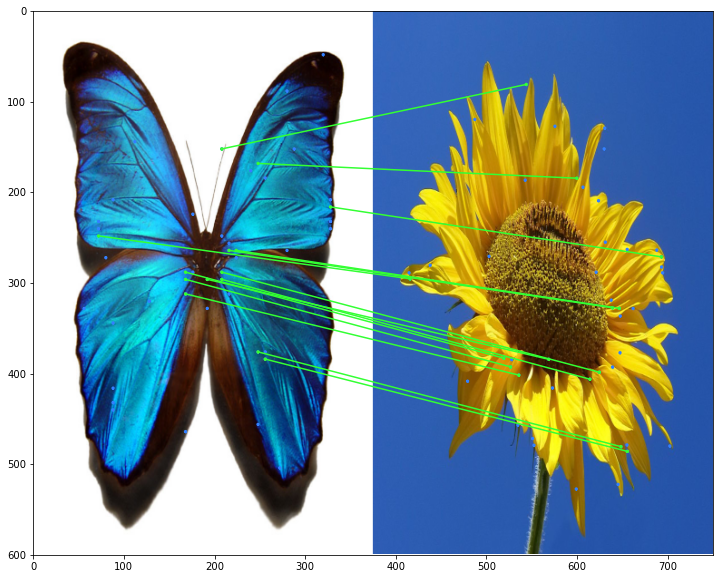

In [13]:
draw_LAF_matches(
    KF.laf_from_center_scale_ori(
        torch.from_numpy(mkpts0).view(1, -1, 2),
        torch.ones(mkpts0.shape[0]).view(1, -1, 1, 1),
        torch.ones(mkpts0.shape[0]).view(1, -1, 1),
    ),
    KF.laf_from_center_scale_ori(
        torch.from_numpy(mkpts1).view(1, -1, 2),
        torch.ones(mkpts1.shape[0]).view(1, -1, 1, 1),
        torch.ones(mkpts1.shape[0]).view(1, -1, 1),
    ),
    torch.arange(mkpts0.shape[0]).view(-1, 1).repeat(1, 2),
    K.tensor_to_image(img1),
    K.tensor_to_image(img2),
    inliers,
    draw_dict={"inlier_color": (0.2, 1, 0.2), "tentative_color": None, "feature_color": (0.2, 0.5, 1), "vertical": False},
)


In [14]:
import kornia.feature as KF
matcher = KF.LoFTR(pretrained="indoor_new")

In [15]:
fname11= "comp with table1.jpg"
fname12 = "com with table 2.jpg"

In [16]:
img1 = K.io.load_image(fname11, K.io.ImageLoadType.RGB32)[None, ...]
img2 = K.io.load_image(fname12, K.io.ImageLoadType.RGB32)[None, ...]

In [17]:
img1 = K.geometry.resize(img1, (400, 600), antialias=True)
img2 = K.geometry.resize(img2, (400, 600), antialias=True)

In [18]:
img1.shape

torch.Size([1, 3, 400, 600])

In [19]:
matcher = KF.LoFTR(pretrained="indoor_new")

input_dict = {
    "image0": K.color.rgb_to_grayscale(img1),  # LofTR works on grayscale images only
    "image1": K.color.rgb_to_grayscale(img2),
}

In [20]:
#pip install opencv-python==4.5.4.60

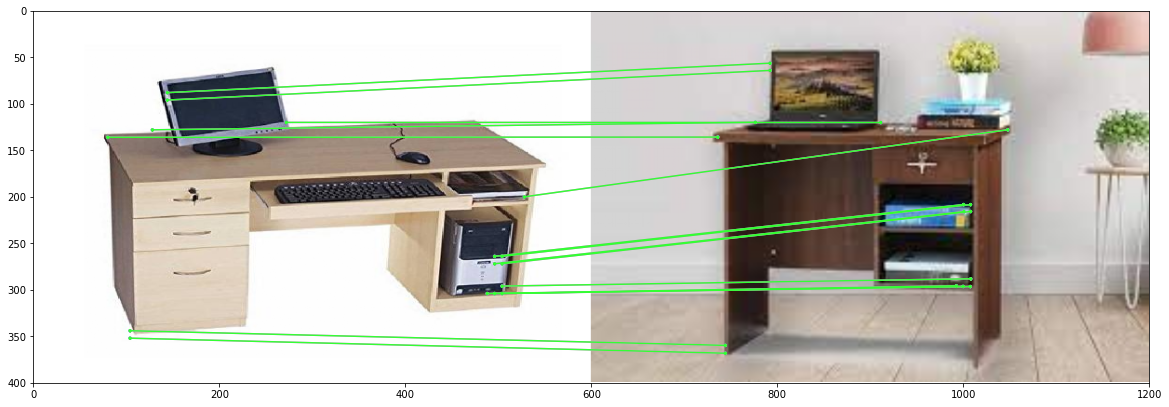

In [21]:
with torch.inference_mode():
    correspondences = matcher(input_dict)

mkpts0 = correspondences["keypoints0"].cpu().numpy()
mkpts1 = correspondences["keypoints1"].cpu().numpy()
Fm, inliers = cv2.findFundamentalMat(mkpts0, mkpts1, cv2.USAC_MAGSAC, 1.0, 0.999, 100000)
inliers = inliers > -2

model=draw_LAF_matches(
    KF.laf_from_center_scale_ori(
        torch.from_numpy(mkpts0).view(1, -1, 2),
        torch.ones(mkpts0.shape[0]).view(1, -1, 1, 1),
        torch.ones(mkpts0.shape[0]).view(1, -1, 1),
    ),
    KF.laf_from_center_scale_ori(
        torch.from_numpy(mkpts1).view(1, -1, 2),
        torch.ones(mkpts1.shape[0]).view(1, -1, 1, 1),
        torch.ones(mkpts1.shape[0]).view(1, -1, 1),
    ),
    torch.arange(mkpts0.shape[0]).view(-1, 1).repeat(1, 2),
    K.tensor_to_image(img1),
    K.tensor_to_image(img2),
    inliers,
    draw_dict={
        "inlier_color": (0.2, 1, 0.2),
        "tentative_color": (1.0, 0.5, 1),
        "feature_color": (0.2, 0.5, 1),
        "vertical": False,
    },
)

In [ ]:
import torch.nn as nn
import kornia.contrib as K

In [ ]:
#pip install torchvision

In [ ]:
pip install pytorch_lightning torchmetrics

In [ ]:
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10

In [ ]:
import os

import kornia as K
import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torchmetrics
from PIL import Image
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10

In [ ]:
class DataAugmentation(nn.Module):
    """Module to perform data augmentation using Kornia on torch tensors."""

    def __init__(self, apply_color_jitter: bool = False) -> None:
        super().__init__()
        self._apply_color_jitter = apply_color_jitter

        self._max_val: float = 255.0

        self.transforms = nn.Sequential(K.enhance.Normalize(0.0, self._max_val), K.augmentation.RandomHorizontalFlip(p=0.5))

        self.jitter = K.augmentation.ColorJitter(0.5, 0.5, 0.5, 0.5)

    @torch.no_grad()  # disable gradients for effiency
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_out = self.transforms(x)  # BxCxHxW
        if self._apply_color_jitter:
            x_out = self.jitter(x_out)
        return x_out

In [ ]:
class PreProcess(nn.Module):
    """Module to perform pre-process using Kornia on torch tensors."""

    def __init__(self) -> None:
        super().__init__()

    @torch.no_grad()  # disable gradients for effiency
    def forward(self, x: Image) -> torch.Tensor:
        x_tmp: np.ndarray = np.array(x)  # HxWxC
        x_out: torch.Tensor = K.image_to_tensor(x_tmp, keepdim=True)  # CxHxW
        return x_out.float()

In [ ]:
class CoolSystem(pl.LightningModule):
    def __init__(self):
        super().__init__()
        # not the best model...
        self.l1 = torch.nn.Linear(3 * 32 * 32, 10)

        self.preprocess = PreProcess()

        self.transform = DataAugmentation()

        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10)

    def forward(self, x):
        return torch.relu(self.l1(x.view(x.size(0), -1)))

    def training_step(self, batch, batch_idx):
        # REQUIRED
        x, y = batch
        x_aug = self.transform(x)  # => we perform GPU/Batched data augmentation
        logits = self.forward(x_aug)
        loss = F.cross_entropy(logits, y)
        self.log("train_acc_step", self.accuracy(logits.argmax(1), y))
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        # OPTIONAL
        x, y = batch
        logits = self.forward(x)
        self.log("val_acc_step", self.accuracy(logits.argmax(1), y))
        return F.cross_entropy(logits, y)

    def test_step(self, batch, batch_idx):
        # OPTIONAL
        x, y = batch
        logits = self.forward(x)
        acc = self.accuracy(logits.argmax(1), y)
        self.log("test_acc_step", acc)
        return acc

    def configure_optimizers(self):
        # REQUIRED
        # can return multiple optimizers and learning_rate schedulers
        # (LBFGS it is automatically supported, no need for closure function)
        return torch.optim.Adam(self.parameters(), lr=0.0004)

    def prepare_data(self):
        CIFAR10(os.getcwd(), train=True, download=True, transform=self.preprocess)
        CIFAR10(os.getcwd(), train=False, download=True, transform=self.preprocess)

    def train_dataloader(self):
        # REQUIRED
        dataset = CIFAR10(os.getcwd(), train=True, download=False, transform=self.preprocess)
        loader = DataLoader(dataset, batch_size=32, num_workers=1)
        return loader

    def val_dataloader(self):
        dataset = CIFAR10(os.getcwd(), train=True, download=False, transform=self.preprocess)
        loader = DataLoader(dataset, batch_size=32, num_workers=1)
        return loader

    def test_dataloader(self):
        dataset = CIFAR10(os.getcwd(), train=False, download=False, transform=self.preprocess)
        loader = DataLoader(dataset, batch_size=16, num_workers=1)
        return loader

In [ ]:
from flask import Flask, render_template, request
from flask import Flask,request
import numpy as np
import pickle
import pandas as pd 

from PIL import Image

app = Flask(__name__)

@app.route('/')
def welcome():
    return "Welcome All"

@app.route('/upload', methods=['POST'])
def upload():
    # Check if both images are uploaded
    if 'image1' not in request.files or 'image2' not in request.files:
        return 'Please upload both images.'

    image1 = request.files['image1']
    image2 = request.files['image2']

    # Perform matching logic here
    # ...

    # Placeholder result
    #match_result = False

    #return render_template('result.html', match_result=match_result)

if __name__ == '__main__':
    app.run(debug=True)

In [ ]:
from flask import Flask,request
import numpy as np
import pickle
import pandas as pd 

from PIL import Image

app=Flask(__name__)

pickle_in = open("outdoor.pkl","rb")
classifier=pickle.load(pickle_in)

@app.route('/')
def welcome():
    return "Welcome All"

@app.route('/predict')
def upload():
    image1 = request.files['image1']
    image2 = request.files['image2']
    
    prediction=classifier.predict([[fname1,fname2]])
    return "The predicted value is"+ str(prediction)

if __name__=='__main__':
    app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [24/Jun/2023 16:31:53] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [24/Jun/2023 16:31:54] "GET /favicon.ico HTTP/1.1" 404 -


In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Sat Jun 13 02:20:31 2020

@author: Krish Naik
"""

# -*- coding: utf-8 -*-
"""
Created on Fri May 15 12:50:04 2020

@author: krish.naik
"""


import numpy as np
import pickle
import pandas as pd
#from flasgger import Swagger
import streamlit as st 

from PIL import Image

#app=Flask(__name__)
#Swagger(app)

pickle_in = open("outdoor.pkl","rb")
classifier=pickle.load(pickle_in)

#@app.route('/')
def welcome():
    return "Welcome All"

#@app.route('/predict',methods=["Get"])
def image matching(fname1,fname2):
    
    """Let's Authenticate the Banks Note 
    This is using docstrings for specifications.
    ---
    parameters:  
      - name: fname1
        in: query
        type: image
        required: true
      - name: fname2
        in: query
        type: image
        required: true
    responses:
        200:
            description: The output values
        
    """
   
    prediction=outdoor.predict([[fname1,fname2]])
    print(prediction)
    return prediction



def main():
    st.title("Image matching")
    html_temp = """
    <div style="background-color:tomato;padding:10px">
    <h2 style="color:white;text-align:center;">Streamlit Image matching ML App </h2>
    </div>
    """
    st.markdown(html_temp,unsafe_allow_html=True)
    fname1 = st.text_input("fname1","Type Here")
    fname2 = st.text_input("fname2","Type Here")
   
    result=""
    if st.button("Predict"):
        result=predict_note(fanme1,fname2)
    st.success('The output is {}'.format(result))
    if st.button("About"):
        st.text("Lets LEarn")
        st.text("Built with Streamlit")

if __name__=='__main__':
    main()

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Sat Jun 13 02:20:31 2020

@author: Krish Naik
"""

# -*- coding: utf-8 -*-
"""
Created on Fri May 15 12:50:04 2020

@author: krish.naik
"""

from flask import Flask, request
import numpy as np
import pickle
import pandas as pd
from flasgger import Swagger

from PIL import Image

#app=Flask(__name__)
#Swagger(app)

pickle_in = open("outdoor.pkl","rb")
classifier=pickle.load(pickle_in)

#@app.route('/')
def welcome():
    return "Welcome All"

@app.route('/predict',methods=["Get"])
def predict_note_authentication(variance,skewness,curtosis,entropy):
    
    """Let's Authenticate the Banks Note 
    This is using docstrings for specifications.
    ---
    parameters:  
      - name: fname1
        in: query
        type: number
        required: true
      - name: fname2
        in: query
        type: number
        required: true
     
    responses:
        200:
            description: The output values
        
    """
   
    prediction=classifier.predict([[variance,skewness,curtosis,entropy]])
    print(prediction)
    return prediction



def main():
    st.title("Bank Authenticator")
    html_temp = """
    <div style="background-color:tomato;padding:10px">
    <h2 style="color:white;text-align:center;">Streamlit Bank Authenticator ML App </h2>
    </div>
    """
    st.markdown(html_temp,unsafe_allow_html=True)
    variance = st.text_input("Variance","Type Here")
    skewness = st.text_input("skewness","Type Here")
    curtosis = st.text_input("curtosis","Type Here")
    entropy = st.text_input("entropy","Type Here")
    result=""
    if st.button("Predict"):
        result=predict_note_authentication(variance,skewness,curtosis,entropy)
    st.success('The output is {}'.format(result))
    if st.button("About"):
        st.text("Lets LEarn")
        st.text("Built with Streamlit")

if __name__=='__main__':
    main()
    